# 1) Install and load dependencies:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# compatibility issues can arise, stick to mentioned versions of tf and tfio
#! pip install tensorflow==2.10.0 tensorflow-io==0.27.0
! pip install tensorflow-io==0.27.0

In [ ]:
import os
import tensorflow as tf
import tensorflow_io as tfio
import  matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.10.0'

# 2) Build data loading function:

#### define paths to a single file for testing:

In [ ]:
# define paths to a single file for testing:

CAPUCHIN_BIRDS = os.path.join("/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/data", "Parsed_Capuchinbird_Clips", "XC3776-0.wav")
NON_CAPUCHIN_BIRDS = os.path.join("/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/data", "Parsed_Not_Capuchinbird_Clips", "afternoon-birds-song-in-forest-0.wav")

In [ ]:
CAPUCHIN_BIRDS

'/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/data/Parsed_Capuchinbird_Clips/XC3776-0.wav'

In [ ]:
NON_CAPUCHIN_BIRDS

'/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav'

#### process to decode wav file:

In [ ]:
# load encoded wav file
file_contents = tf.io.read_file(CAPUCHIN_BIRDS)

# decode wav (tensors by channels)
wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)

# remove trailing axis
wav2 = tf.squeeze(wav, axis = -1)
sample_rate = tf.cast(sample_rate, dtype = tf.int64)

# covnert amplitude from 44100 hz to 16000 hz
wav3 = tfio.audio.resample(wav2, rate_in = sample_rate, rate_out = 16000)

In [ ]:
wav

<tf.Tensor: shape=(132300, 1), dtype=float32, numpy=
array([[-0.1289978 ],
       [-0.15133667],
       [-0.14691162],
       ...,
       [ 0.11514282],
       [ 0.10748291],
       [ 0.1100769 ]], dtype=float32)>

In [ ]:
wav2

<tf.Tensor: shape=(132300,), dtype=float32, numpy=
array([-0.1289978 , -0.15133667, -0.14691162, ...,  0.11514282,
        0.10748291,  0.1100769 ], dtype=float32)>

In [ ]:
wav3

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([ 1.0432389e-06, -3.0215922e-06,  1.9820709e-06, ...,
       -4.5542806e-02, -5.4887902e-02, -8.5778177e-02], dtype=float32)>

In [ ]:
sample_rate

<tf.Tensor: shape=(), dtype=int64, numpy=44100>

In [ ]:
def load_wav_16k_mono(filename):
  # load encoded wav file
  file_contents = tf.io.read_file(filename)

  # decode wav (tensors by channels)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)

  # remove trailing axis
  wav = tf.squeeze(wav, axis = -1)
  sample_rate = tf.cast(sample_rate, dtype = tf.int64)

  # covnert amplitude from 44100 hz to 16000 hz
  wav = tfio.audio.resample(wav, rate_in = sample_rate, rate_out = 16000)
  return wav

### Plot wave for capuchin and non-capuchin bird examples:

In [ ]:
wave = load_wav_16k_mono(CAPUCHIN_BIRDS)
nwave = load_wav_16k_mono(NON_CAPUCHIN_BIRDS)

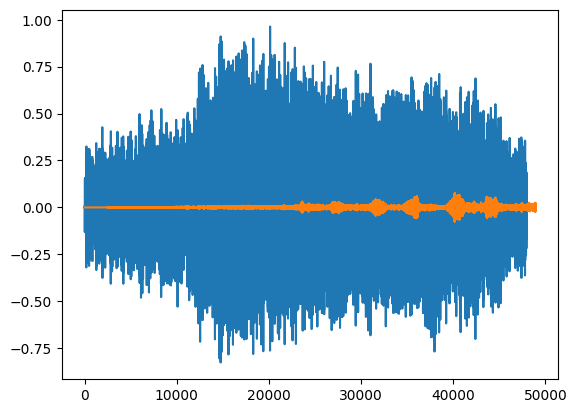

In [ ]:
plt.plot(wave) # blue graph
plt.plot(nwave) # orange graph
plt.show()

# 3) Create tensorflow dataset:

### we will convert our waveforms into a spectogram using a fourier transform. The spectogram is an image representation of the audio file, allowing CNNs to be used on audio files for classificaition

In [ ]:
# deine paths to positive and negative data:
POS = os.path.join("/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/data", "Parsed_Capuchinbird_Clips")
NEG = os.path.join("/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/data", "Parsed_Not_Capuchinbird_Clips")

In [ ]:
POS

'/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/data/Parsed_Capuchinbird_Clips'

In [ ]:
# create tensorflow datasets:

pos = tf.data.Dataset.list_files('/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/data/Parsed_Capuchinbird_Clips/*.wav')
neg = tf.data.Dataset.list_files('/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/data/Parsed_Not_Capuchinbird_Clips/*.wav')

In [ ]:
# add labels to all audio file paths

positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

data = positives.concatenate(negatives)

In [ ]:
tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float32, name=None)>

In [ ]:
data.shuffle(1000).as_numpy_iterator().next()

(b'/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/data/Parsed_Not_Capuchinbird_Clips/rain-thunder-and-crickets-sound-effect-31.wav',
 0.0)

# 4) determine avg length of Capuchin call:

In [ ]:
# calculate wave cycle length:

lengths = []

for file in os.listdir('/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/data/Parsed_Capuchinbird_Clips/'):
  tensor_wave = load_wav_16k_mono(os.path.join('/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/data/Parsed_Capuchinbird_Clips/', file))
  lengths.append(len(tensor_wave))


lengths[:5]

[48000, 48000, 56000, 56000, 56000]

In [ ]:
# mean, median, min, max

print(tf.math.reduce_mean(lengths)) # 54156/16000 ~ 3.38 secs approx each capuchin call
print(tf.math.reduce_min(lengths)) # aprrox 2 secs
print(tf.math.reduce_max(lengths)) # approx 5 secs

tf.Tensor(54156, shape=(), dtype=int32)
tf.Tensor(32000, shape=(), dtype=int32)
tf.Tensor(80000, shape=(), dtype=int32)


# 5) Convert data into a spectogram:

# build preprocessing function:

In [ ]:
def preprocess(file_path, label):
  wav = load_wav_16k_mono(file_path)
  wav = wav[:48000] # we will take in the first 48000 data points of the wav

  # for files with less than 48000 data points, we will pad with 0
  zero_padding = tf.zeros([48000] - tf.shape(wav), dtype = tf.float32) # number of zeros to add at start
  wav = tf.concat([zero_padding, wav], 0)

  # stft = short time fourier transform
  spectogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
  spectogram = tf.abs(spectogram)
  spectogram = tf.expand_dims(spectogram, axis = 2) # enclose with another array making it 3 dim
  return spectogram, label


In [ ]:
wav = load_wav_16k_mono(CAPUCHIN_BIRDS)
len(wav)

48000

In [ ]:
wav = wav[:48000]
zero_padding = tf.zeros([48000] - tf.shape(wav), dtype = tf.float32)
wav = tf.concat([zero_padding, wav], 0)
wav

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([ 1.0432389e-06, -3.0215922e-06,  1.9820709e-06, ...,
       -4.5542806e-02, -5.4887902e-02, -8.5778177e-02], dtype=float32)>

In [ ]:
zero_padding.shape

TensorShape([0])

In [ ]:
[48000] - tf.shape(wav)

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>

In [ ]:
spectogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
spectogram

<tf.Tensor: shape=(1491, 257), dtype=complex64, numpy=
array([[ 1.92845762e-02+0.0000000e+00j,  2.49077938e-02-3.6792555e-03j,
         2.54349727e-02-1.4371764e-02j, ...,
        -3.02526169e-04+8.6017884e-05j,  2.38372944e-04+8.9241774e-05j,
        -4.28557396e-05+0.0000000e+00j],
       [-9.84263420e-03+0.0000000e+00j, -1.12457480e-03+6.0149306e-03j,
        -8.06703698e-03+2.7199639e-03j, ...,
        -2.30411068e-04+3.9909664e-04j,  1.86778372e-04-1.4095870e-04j,
        -2.18436122e-04+0.0000000e+00j],
       [-1.10914782e-02+0.0000000e+00j,  5.01295831e-03+3.5791681e-03j,
        -5.90727059e-03-6.5621566e-03j, ...,
         2.95928214e-04+4.1986490e-04j,  1.05059706e-04-2.8449204e-04j,
        -2.13377178e-04+0.0000000e+00j],
       ...,
       [-6.36870414e-03+0.0000000e+00j,  3.23508540e-03+6.6639883e-03j,
         1.73491165e-02-7.8690134e-04j, ...,
        -5.11235557e-04+2.8592392e-04j,  2.17924942e-04+1.3842876e-04j,
        -1.53258443e-05+0.0000000e+00j],
       [-5.72

In [ ]:
spectogram = tf.expand_dims(spectogram, axis = 2)
spectogram

<tf.Tensor: shape=(1491, 257, 1), dtype=complex64, numpy=
array([[[ 1.92845762e-02+0.0000000e+00j],
        [ 2.49077938e-02-3.6792555e-03j],
        [ 2.54349727e-02-1.4371764e-02j],
        ...,
        [-3.02526169e-04+8.6017884e-05j],
        [ 2.38372944e-04+8.9241774e-05j],
        [-4.28557396e-05+0.0000000e+00j]],

       [[-9.84263420e-03+0.0000000e+00j],
        [-1.12457480e-03+6.0149306e-03j],
        [-8.06703698e-03+2.7199639e-03j],
        ...,
        [-2.30411068e-04+3.9909664e-04j],
        [ 1.86778372e-04-1.4095870e-04j],
        [-2.18436122e-04+0.0000000e+00j]],

       [[-1.10914782e-02+0.0000000e+00j],
        [ 5.01295831e-03+3.5791681e-03j],
        [-5.90727059e-03-6.5621566e-03j],
        ...,
        [ 2.95928214e-04+4.1986490e-04j],
        [ 1.05059706e-04-2.8449204e-04j],
        [-2.13377178e-04+0.0000000e+00j]],

       ...,

       [[-6.36870414e-03+0.0000000e+00j],
        [ 3.23508540e-03+6.6639883e-03j],
        [ 1.73491165e-02-7.8690134e-04j],
  

### test out the function and visualize the spectrogram:

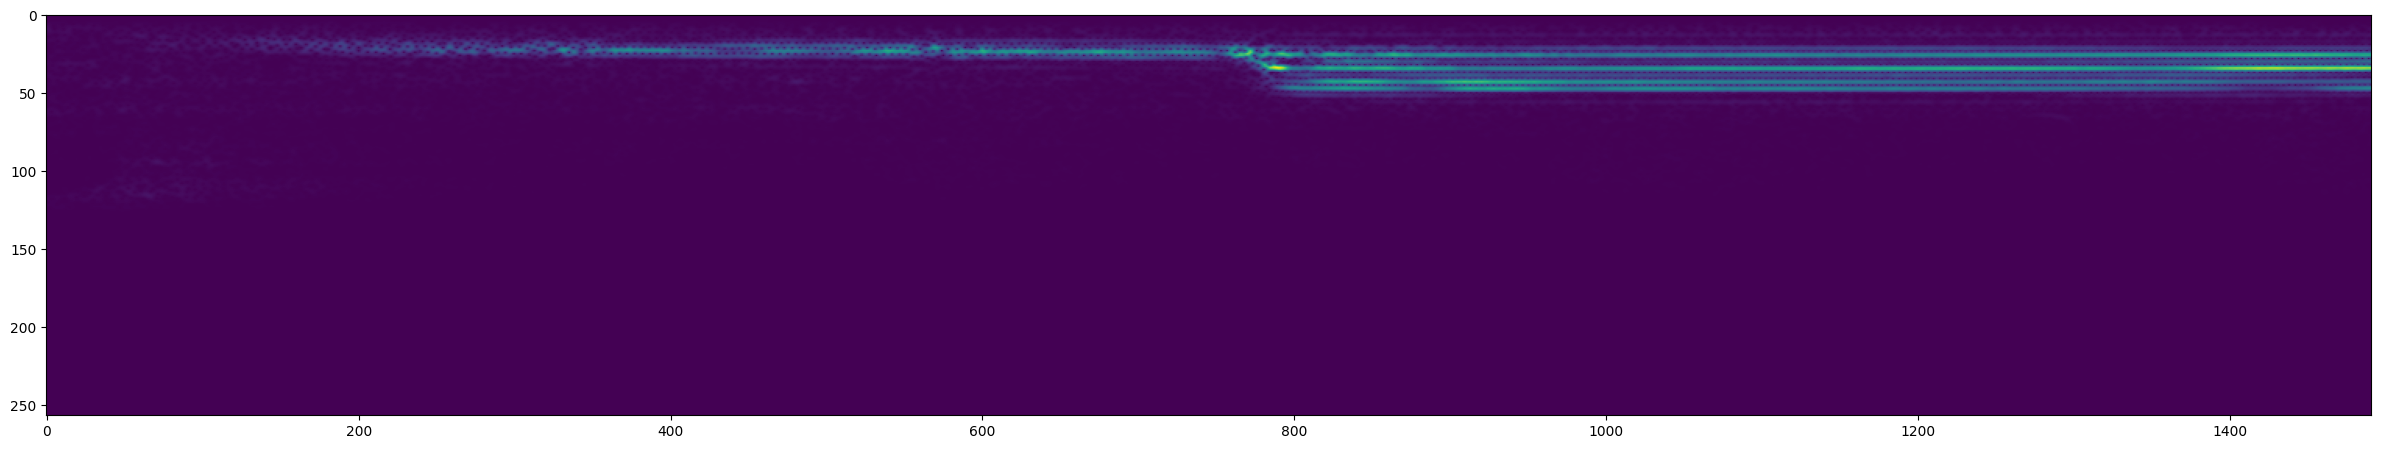

In [ ]:
# positive sample viz
file_path, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(file_path, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0]) #graph will be vertical without transponse
plt.show()

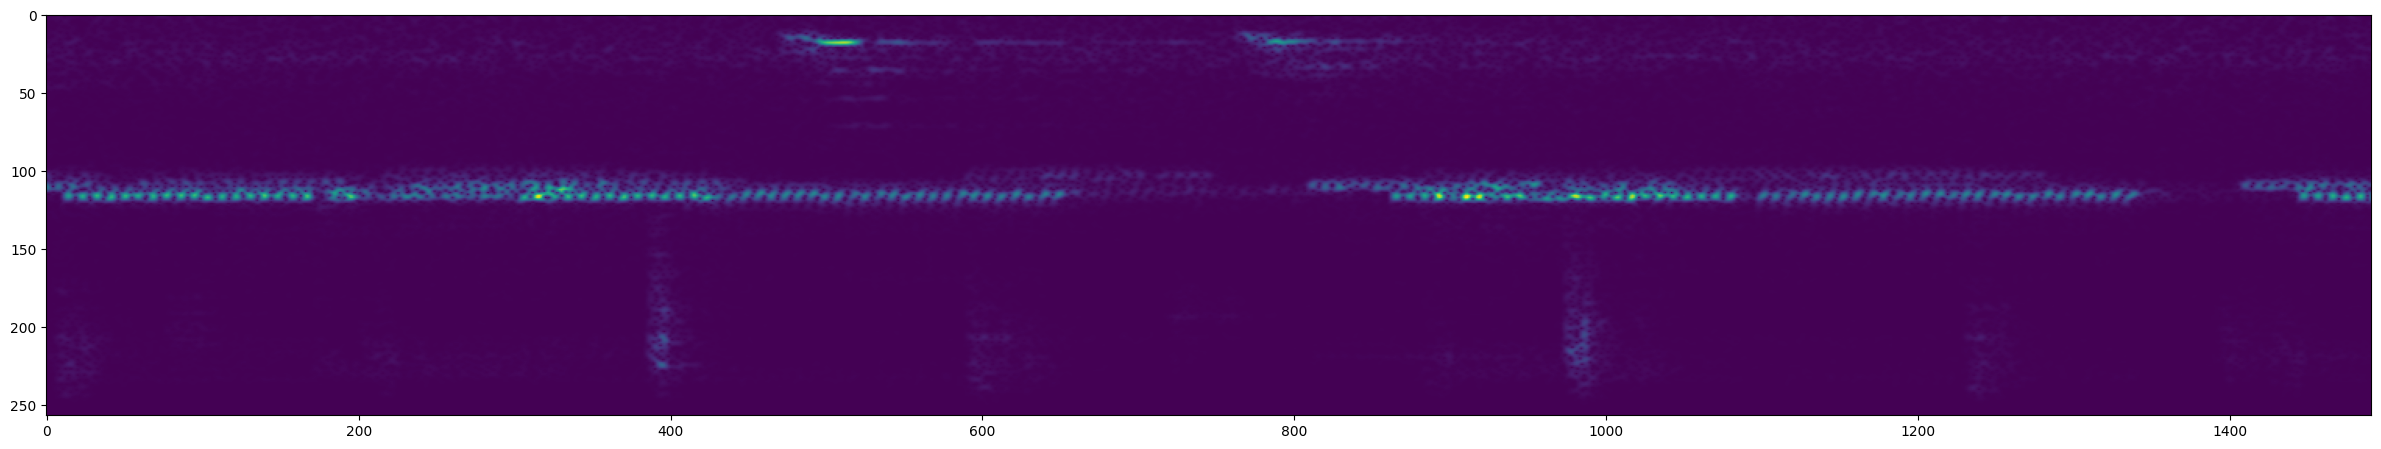

In [ ]:
# negative sample viz
file_path, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(file_path, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0]) #graph will be vertical without transponse
plt.show()

# 6) Train and Test Partitions:


### Create tf data pipeline:

In [ ]:
# right now data only contains filepath and label:
data.shuffle(1000).as_numpy_iterator().next()

(b'/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/data/Parsed_Not_Capuchinbird_Clips/dove-bird-sounds-6.wav',
 0.0)

In [ ]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size = 10000)
data = data.batch(16)
data = data.prefetch(8)

In [ ]:
# split into train and test
len(data), len(data) * 0.7

(51, 35.699999999999996)

In [ ]:
train = data.take(36)
test = data.skip(36).take(15)

In [ ]:
# have a look at a few samples
# samples, labels = train.as_numpy_iterator().next()
# samples.shape

# 7) Build DL model:

In [ ]:
# load dependencies:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D

In [ ]:
# build sequential model, compile and view summary:

model = Sequential()
model.add(Conv2D(16, (3,3), activation = 'relu', input_shape = (1491, 257, 1)))
model.add(MaxPool2D(3,3))
model.add(Conv2D(16, (3,3), activation = 'relu'))
# model.add(MaxPool2D(3,3))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile('Adam', loss = 'BinaryCrossentropy', metrics = [tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 496, 85, 16)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 494, 83, 16)       2320      
                                                                 
 flatten_2 (Flatten)         (None, 656032)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               83972224  
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                      

In [ ]:
hist = model.fit(train, epochs = 4, validation_data = test)

Epoch 1/4
36/36 [==============================] - 198s 5s/step - loss: 0.5464 - recall_2: 0.8797 - precision_2: 0.8797 - val_loss: 0.0379 - val_recall_2: 0.9851 - val_precision_2: 0.9706
Epoch 2/4
36/36 [==============================] - 161s 4s/step - loss: 0.0108 - recall_2: 0.9876 - precision_2: 0.9937 - val_loss: 0.0060 - val_recall_2: 0.9844 - val_precision_2: 1.0000
Epoch 3/4
36/36 [==============================] - 160s 4s/step - loss: 0.0538 - recall_2: 0.9682 - precision_2: 0.9806 - val_loss: 0.2259 - val_recall_2: 0.9403 - val_precision_2: 1.0000
Epoch 4/4
36/36 [==============================] - 157s 4s/step - loss: 0.1066 - recall_2: 0.9815 - precision_2: 0.9815 - val_loss: 0.0208 - val_recall_2: 1.0000 - val_precision_2: 1.0000


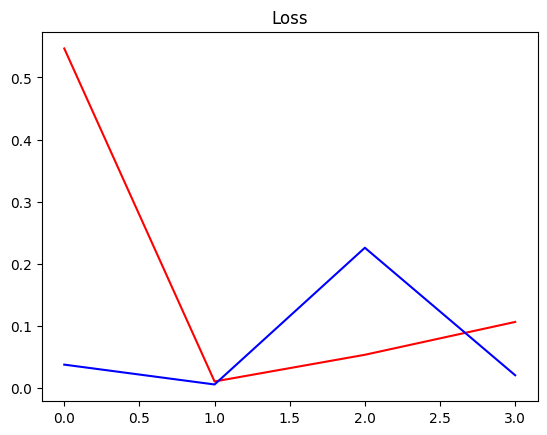

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [ ]:
hist.history

{'loss': [0.5464445352554321,
  0.010818297043442726,
  0.05375736579298973,
  0.10657929629087448],
 'recall_2': [0.8797468543052673,
  0.9875776171684265,
  0.9681528806686401,
  0.9814814925193787],
 'precision_2': [0.8797468543052673,
  0.9937499761581421,
  0.9806451797485352,
  0.9814814925193787],
 'val_loss': [0.0379132442176342,
  0.005982067435979843,
  0.2259182631969452,
  0.020822936668992043],
 'val_recall_2': [0.9850746393203735, 0.984375, 0.9402984976768494, 1.0],
 'val_precision_2': [0.970588207244873, 1.0, 1.0, 1.0]}

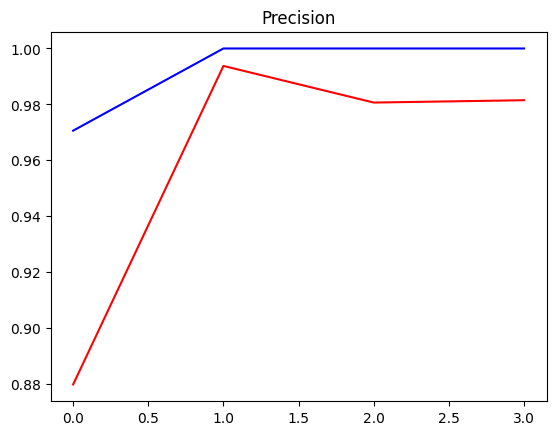

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision_2'], 'r')
plt.plot(hist.history['val_precision_2'], 'b')
plt.show()

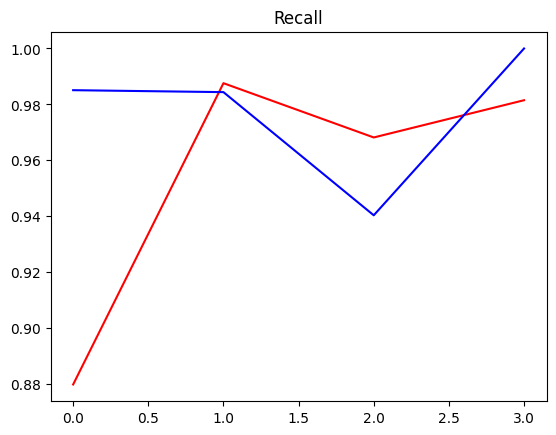

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall_2'], 'r')
plt.plot(hist.history['val_recall_2'], 'b')
plt.show()

# 8) Make a prediction on single clip:

In [ ]:
# make a prediction on one batch:

X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)

1/1 [==============================] - 3s 3s/step


In [ ]:
# convert logits to classes:

yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
yhat

[0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [ ]:
tf.math.reduce_sum(yhat), tf.math.reduce_sum(y_test)

(<tf.Tensor: shape=(), dtype=int32, numpy=4>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.0>)

# 9) Build forest parsing functions:

In [ ]:
# work with full length clips in forest folder:

# load up .mp3 files
def load_mp3_16k_mono(filename):

  #  """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """

  # load encoded wav file
  res = tfio.audio.AudioIOTensor(filename)

  #convert to tensor and combine channels
  tensor = res.to_tensor()
  tensor = tf.math.reduce_sum(tensor, axis = 1)/2

  #extract sample rate and cast
  sample_rate = res.rate
  sample_rate = tf.cast(sample_rate, dtype = tf.int64)

  #resample to 16k hz
  wav = tfio.audio.resample(tensor, rate_in = sample_rate, rate_out = 16000)
  return wav

In [ ]:
mp3 = os.path.join("/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/data", "Forest Recordings", "recording_00.mp3")
wav = load_mp3_16k_mono(mp3)
wav

<tf.Tensor: shape=(2880666,), dtype=float32, numpy=
array([ 8.1433272e-12, -5.7019250e-12, -5.3486417e-12, ...,
       -1.1291276e-02, -1.4230422e-02, -3.0555837e-03], dtype=float32)>

In [ ]:
# slice mp3

audio_slices = tf.keras.utils.timeseries_dataset_from_array(
    wav,
    wav,
    sequence_length=48000,
    sequence_stride=48000, # 48000
    batch_size=1)

In [ ]:
len(audio_slices), audio_slices

(60,
 <BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
len(audio_slices), samples.shape

(60, (1, 48000))

In [ ]:
# build a function to convert clips into windowed spectrograms:

def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
# convert longer clips into windows and make predictions:

audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
# make predictions:

yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]
yhat

1/1 [==============================] - 5s 5s/step


[0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
len(yhat)

60

In [ ]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=11>

In [ ]:
# Group Consecutive Detections

from itertools import groupby

yhat = [key for key, group in groupby(yhat)]
print(yhat)
calls = tf.math.reduce_sum(yhat).numpy()
print("==========")
print(calls)

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
5


# 10) Make predictions on all files in forest directory:

In [ ]:
results = {}

for file in os.listdir(os.path.join("/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/data", "Forest Recordings")):
  FILEPATH = os.path.join("/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/data", "Forest Recordings", file)

  wav = load_mp3_16k_mono(FILEPATH)
  audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
  audio_slices = audio_slices.map(preprocess_mp3)
  audio_slices = audio_slices.batch(64)
  yhat = model.predict(audio_slices)

  results[file] = yhat

1/1 [==============================] - 5s 5s/step


In [ ]:
# CONVERT PREDICTIONS TO CLASSES:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_19.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_18.mp3': [0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1],
 'recording_17.mp3': [0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0],
 'recording_16.mp3': [0,
  0,
  0,
  

In [ ]:
# GROUP CONSECUTIVE DECISIONS:

postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_19.mp3': 2,
 'recording_18.mp3': 16,
 'recording_17.mp3': 8,
 'recording_16.mp3': 5,
 'recording_15.mp3': 2,
 'recording_14.mp3': 0,
 'recording_13.mp3': 0,
 'recording_12.mp3': 1,
 'recording_11.mp3': 3,
 'recording_10.mp3': 5,
 'recording_09.mp3': 0,
 'recording_08.mp3': 12,
 'recording_07.mp3': 2,
 'recording_05.mp3': 0,
 'recording_06.mp3': 6,
 'recording_04.mp3': 5,
 'recording_02.mp3': 0,
 'recording_01.mp3': 0,
 'recording_03.mp3': 0,
 'recording_00.mp3': 5,
 'recording_43.mp3': 5,
 'recording_41.mp3': 0,
 'recording_42.mp3': 0,
 'recording_40.mp3': 1,
 'recording_39.mp3': 1,
 'recording_37.mp3': 4,
 'recording_38.mp3': 10,
 'recording_36.mp3': 6,
 'recording_35.mp3': 0,
 'recording_34.mp3': 4,
 'recording_33.mp3': 0,
 'recording_32.mp3': 2,
 'recording_31.mp3': 1,
 'recording_30.mp3': 3,
 'recording_29.mp3': 18,
 'recording_28.mp3': 1,
 'recording_27.mp3': 0,
 'recording_26.mp3': 2,
 'recording_25.mp3': 2,
 'recording_24.mp3': 0,
 'recording_23.mp3': 5,
 'recording_

In [ ]:
# EXPORT RESULTS AS CSV

import csv
with open('/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])